# [Project 4]_유가_데이터를_활용한_주유소_시장분석

---

## 1. 데이터 Cleansing 및 Feature Engineering

필요한 패키지를 `import`한 후 분석을 위한 사전 점검과 함께 데이터 개괄을 이해합니다.

### 1.1. 18년 데이터 기준 데이터 점검 및 Cleansing

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus']=False

In [ ]:
# csv 파일을 불러오는 메소드.
f18 = pd._____(f'./data/과거_판매가격(주유소)_2018.csv')

In [ ]:
f18.head()

In [ ]:
# 0번 row 제거

f18 = __________

In [ ]:
f18.head()

Nan 값 확인

In [ ]:
f18.________

In [ ]:
# ______ : 카테고리형 변수도 정보 제공
f18.describe(_______)

#### describe 점검 포인트:
- unique 번호가 11673개이며 최대 7번까지 기록되었음
- 기간이 수치로 인식되고 있음
- unique 지역 개수가 229이어서 너무 많음
- unique 상표 개수가 9개이므로 적절함
- unique 셀프여부 개수가 2개이며, 셀프여부는 각각 절반정도 비중을 차지함
- 휘발유 min이 0임

### 기간 정보를 숫자에서 datetime 형태로 변환

실수형->정수형->문자열->날짜

In [ ]:
# 기간을 datetime 형태로 변환

f18['기간'] = f18['기간'].______(lambda x : _______)

### 지역 수 줄이기

모든 지역의 형태가 '강원 강릉시'와 같이 한 칸을 띄고 표시되어 있는지를 먼저 확인

In [ ]:
region_names = []
for region in f18['지역']:
    names = region.split()
    if len(names) != 2:
        region_names.append(region)
        
print(set(region_names))

'세종시'는 하나의 단어로 이뤄짐.

In [ ]:
'세종시'.split()[0]

모든 '지역' column의 데이터를 공백을 기준으로 둘로 분할하여 그 첫번째 요소 ("강원")만을 남김.

In [ ]:
f18['지역2'] = f18['지역']._____(lambda x:x.________)
f18.head()

In [ ]:
# 각 지역들이 몇 번 등장 했는지 횟수 세보기.

f18['지역2'].__________

### 휘발유 값이 0인 경우 확인하기

In [ ]:
# 휘발유값 0인 ROW 확인

price_zero = f18.loc[_________]
print(len(price_zero))
price_zero.head(10)

In [ ]:
# 휘발유값 0인 ROW 제거
f18 = ___________

In [ ]:
f18.describe(include='all')

### 정합성 검사

주유소 별로 7일 동안 '지역', '상표', '셀프여부'가 변화 없었다는 전제 하에 정합성 검사를 실시.

In [ ]:
#주유소별 데이터 정합성 확인(7일동안 변화 없었다는 전제)
# '지역', '상표', '셀프여부'의 유니크한 값의 수를 표시.
unique_count = f18.groupby('번호')[['지역','상표','셀프여부']]._______()
unique_count.head()

In [ ]:
# unique_count가 1이 아니다 = 7일동안 '지역', '상표', '셀프여부'에 변동이 있었다.
# unique_count가 1이 아닌 수(sum)의 총 개수가 0이 아닐 경우
# 적절한 비교 연산자 넣기.
target = unique_count.loc[(unique_count__1).sum(axis=1)__0]
target

In [ ]:
f18.loc[f18['번호'].isin(target.index)]

In [ ]:
# target.index에 포함되는 인덱스를 갖는 f18의 데이터 제거하기.

f18 = f18.loc[____________________________]

In [ ]:
# 주유소별 데이터 통합
# 각 column들의 첫번째 값을 사용하며, 휘발유의 경우 평균값으로 적용.
f18 = f18.groupby('번호')\
    .___({'지역':______,'지역2':______,'상표':______,'셀프여부':______,'휘발유':____})\
    .reset_index()

In [ ]:
f18.head()

In [ ]:
f18.describe(include='all')

### 1.2. Cleansing 및 Feature Engineering 함수 생성 및 전체 년도 데이터 적용

In [ ]:
def preprocess(df):
    df_copy=df.copy()
    
    df = df.drop(0)
    df['기간'] = df['기간'].apply(lambda x:pd.to_datetime(str(int(x))))
    df['지역2'] = df['지역'].apply(lambda x:x.split()[0])
    df = df.loc[df['휘발유']!=0,:]
    unique_count = df.groupby('번호')[['번호','지역','상표','셀프여부']].nunique()
    target = unique_count.loc[(unique_count!=1).sum(axis=1)!=0,:]
    df = df.loc[~df['번호'].isin(target.index),:]
    df = df.groupby('번호')\
        .agg({'지역':'first','지역2':'first','상표':'first','셀프여부':'first','휘발유':'mean'})\
        .reset_index()

    # 두 dataframe 사이의 차이를 확인하는 함수.
    out = set(df_copy['번호']).___________(set(df['번호'])) # 필터링 후 사라진 주유소의 id 
    return (df,out)

In [ ]:
f_dict = dict()
out_all = set() # 이상치 발견한 주유소 번호 저장
for year in range(2018,2022):
    # csv 읽어오는 메소드.
    df = pd.________(f'./data/과거_판매가격(주유소)_{year}.csv')
    f_dict[year], out = preprocess(df)
    out_all.update(out)

In [ ]:
f_dict[2021].head()

### 1.3. 연도별 데이터 Outer Join

각 연도의 데이터 프레임을 merge해서 아래와 같은 결과를 만든다.

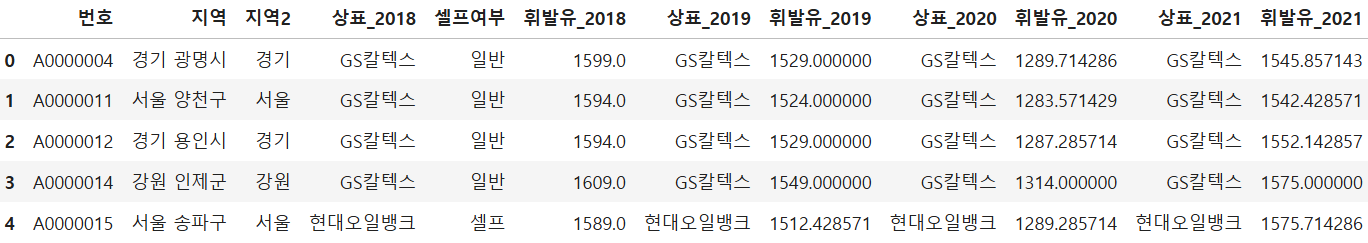

In [ ]:
key = list(f_dict[2018].columns)
key.remove('휘발유')
key.remove('상표')

m1 = pd._____(f_dict[2018], f_dict[2019], on=___, how=_______, suffixes=(_____________))
m2 = pd.merge(_________________________________________________________________________)
m = pd.merge(m1,m2,on=___,how=_________)

정상적으로 처리되었다면, 모든 주유소의 정보가 한 개의 행으로 표현되어 있어야 함.

In [ ]:
# '번호' column을 기준으로 그룹으로 묶은 뒤, 그 크기를 계산.
size = m.______('번호').______

In [ ]:
# 계산된 횟수를 내림차순으로 정렬.
size = size._____________(_____________)
size.head()

In [ ]:
m.loc[m['번호']=='A0033348']

중간에 지역이 바뀐 것을 확인 가능.

In [ ]:
target = size[size>1].index
target

지역이 변한 것은 개수가 많지 않음 + 정합성 의심 되므로 제거.

In [ ]:
# 주유소 ID('번호')가 target에 포함되지 않는 값만 저장.
m = m.loc[________________]

In [ ]:
# 정말 모든 주유소ID가 한번씩만 사용됐는지 마지막으로 확인.
m.groupby('번호').size().sort_values(ascending=False).head()

정합성 검사를 통과하지 못했던 주유소 id들을 필터링.

In [ ]:
# 이상치 발견되었던 주유소 필터링
m = m.loc[[x not in out_all for x in m['번호']]]

In [ ]:
m.head()

* 핵심은 'Nan'값 등의 이상한 값 처리. (제거? 대체?)

* 데이터 정합성 확인 - 이 데이터가 신뢰할 만한 데이터인가?

---

## 2. 주유소 개폐업 현황 분석: 연도별 주유소 ID 비교를 통한 개폐업 현황 분석


### 2.1. 연도별 개폐업 수치 분석

2018~2021년 사이에 주유소가 문을 닫거나 연 경우, 해당 연도의 상표에 Nan이 저장되어 있다는 것을 이용

각 연도 별로 해당 연도에 존재하는 주유소 리스트를 id_dict에 dictionary 형태로 저장

In [ ]:
id_dict=dict()
for year in range(2018,2022):
    # non_null_brand : f'상표+{year}'에 null이 포함되지 않는 행들을 추가.
    non_null_brand = ___________________________________
    # opened_list : non_null_brand의 '번호' column의 유니크한 값들을 저장.
    opened_list = ________________________
    id_dict[year] = set(opened_list)

주유소가 새로 생긴 경우(opened)와 사라진 경우(closed)를 id_dict를 이용해서 체크!

In [ ]:
diff_dict=dict()
# 2019년엔 있는데 2018년엔 없다 => 2019년에 개업.
# 2020년엔 있는데 2021년엔 없다. => 2020년에 폐업.
for year in range(2018,2021):
    opened = len(id_dict[year+1].difference(id_dict[year]))
    closed = len(id_dict[year].difference(id_dict[year+1]))
    diff_dict[f'{year}_{year+1}']=[opened,closed]
diff_df = pd.DataFrame(diff_dict,index=['OPENED','CLOSED'])  

In [ ]:
diff_df

아래와 같이 개점 수와 폐점 수 비교 그래프 그리기

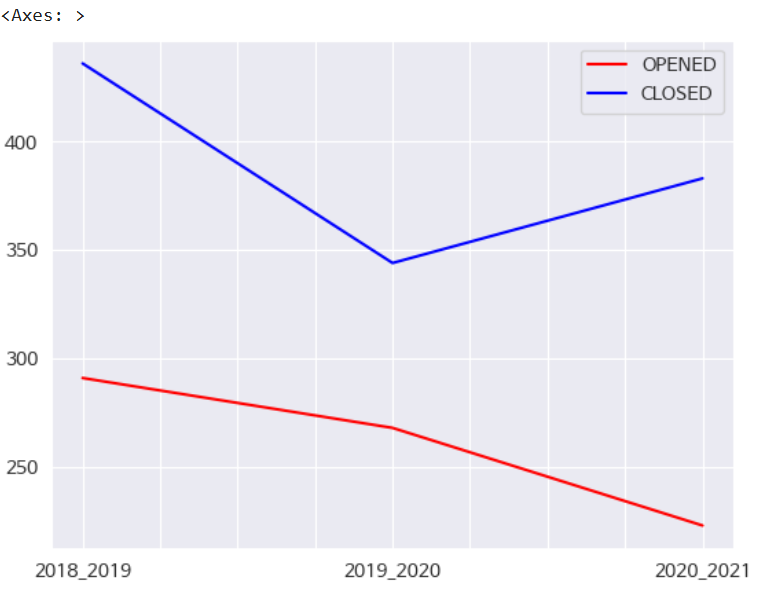

In [ ]:
# 개점 수와 폐점 수 그래프 그리기
______________________

#### 퀴즈 1. 2021년에 폐업한 '경기' 주유소의 개수를 구하시오.

---

## 3. 브랜드 분석: 브랜드별 가격경쟁력 및 시장점유율 분석


### 3.1. 주요 브랜드별 가격 Line Plot 분석

In [ ]:
brand_price_dict=dict()
for year in range(2018,2022):
    # f'상표_{year}'로 묶는다.
    groups = m._______(________)
    # 각 상표 그룹의 휘발유 평균 가격을 저장한다.
    mean_price = groups[f'휘발유_{year}'].____()
    brand_price_dict[str(year)] = mean_price

In [ ]:
# pandas DataFrame으로 변환
brand_price_df = pd._________(brand_price_dict)
brand_price_df

In [ ]:
# 'SK가스' 인덱스 제거하기.

brand_price_df = brand_price_df.___________

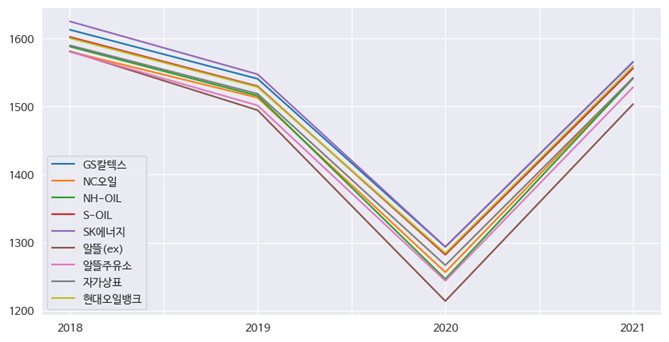

In [ ]:
# 위 그림과 같이 그래프 그리기

_________________________________________

### 3.2. 주요 브랜드별 지난 4년간 시장 점유율 Stacked Bar Plot 및 Heatmap

각 브랜드의 4년간 시장 정뮤율을 stacked bar와 heatmap으로 그려보자.

In [ ]:
brand_share_dict=dict()
for year in range(2018,2022):
    brand_share_dict[str(year)]=m.groupby(f'상표_{year}').size()

In [ ]:
brand_share_df = pd.DataFrame(brand_share_dict)
brand_share_df

In [ ]:
brand_share_df = brand_share_df.drop('SK가스')
# x/brand_share_df.sum() : 각 연도 별로 주유소 점유율을 계산.
brand_ratio_df = brand_share_df.apply(lambda x:x/brand_share_df.sum(),axis=1)
brand_ratio_df = brand_ratio_df.sort_values('2018',ascending=False)

In [ ]:
# 각 column의 총합이 1로 나타난다.
brand_ratio_df

In [ ]:
# 스택형 막대 그래프 그리기.
brand_ratio_df.T.plot(_________________,rot=0,figsize=(10,5))
# bbox_to_anchor=(1, 1) : legend() 박스가 그래프의 오른쪽에 위치하도록.
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
# 그래프 크기 조절하기
plt.figure(_______=(10,5))
# 히트맵 그리기
sns._______(brand_ratio_df, cmap='RdBu_r', linewidths=1, linecolor='black',annot=True)

#### 퀴즈 2. 2019년에 운영 중인 주유소들이 각 지역에 얼마나 있는지 비율을 계산하고, 막대 그래프로 그려 보세요.
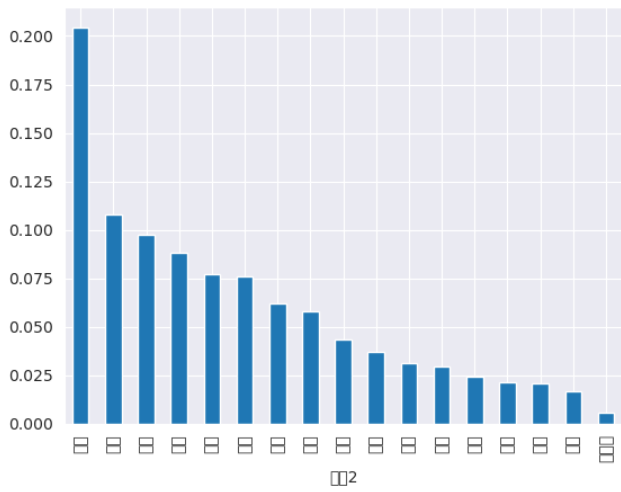

In [ ]:
# 위와 같이 2019년에 운영 중인 주유소들이 각 지역에 얼마나 있는지에 대한 비율을 막대 그래프로 그려보기.


---

## 4. **가격 분석:** 주유소 및 지역 별 가격 편차 분석

**BoxPlot**

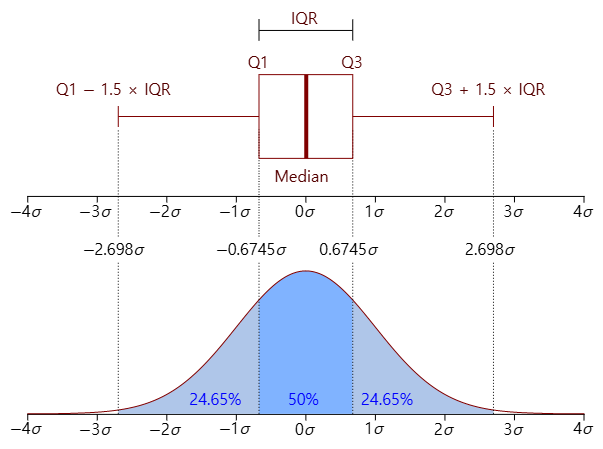

* 박스의 중앙선 = 전체 데이터의 중앙값(median)
* 박스 영역 = 하위 25%(Q1) ~ 상위 75%(Q3)의 범위를 나타냄.
* 이 박스 영역을 IQR(Q3-Q1)이라고 한다.
* 박스 좌우의 선은 Q1과 Q3에 1.5를 곱한 범위를 나타낸다. (이 범위를 넘어가면 '이상치'라고 판단한다.)

### 4.1. 가격 분포 Boxplot

### 4.2. 지역별 가격 분포 Boxplot (Multiple Columns)

In [ ]:
# 1. 지역2로 묶는다.
boxplot_order = m._______('지역2')
# 2. '휘발유_2021'의 '중간값'을 내림차순으로 정렬한다.
boxplot_order = boxplot_order[_____].______.__________(ascending=_____)
boxplot_order = boxplot_order.index

아래와 같은 seaborn boxplot을 그린다.

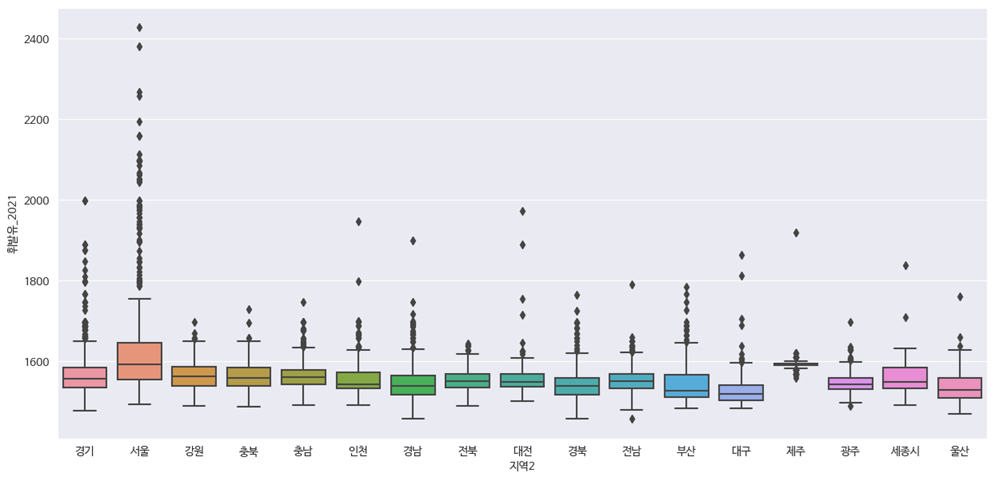

In [ ]:
# 위 그림과 같이 seaborn 그래프 그리기.
plt.figure(figsize=(15,7))
sns._______(x=_____, y=_______, data=_, orient="v", order=boxplot_order)

* 서울이 평균적으로 기름값이 비싸다.
* 제주도는 기름값이 대체로 균일하다.

 ---

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>